# 6. Manipulating Time-series

Time-series are a key element when assessing solar resource data. In this section, we present several examples to learn how to deal with different formats in the data and few common tasks to prepare our time-series for later analysis, such as down and up-sampling data when we need different temporal resolution that initially available and interpolating to deal with missing data. 

The dataset used in the examples of this section is an extract of the dataset from the Technical University of Denmark used in the previous section on [Quality Assessment](https://nbviewer.jupyter.org/github/AssessingSolar/Solar-Resource-Assessment-in-Python/blob/main/notebooks/quality_asessment.ipynb) with 1-minute GHI, DHI and DNI measurements, which has been customised by adding columns with time-related data and sliced to take the data from 2019 to perform the examples. The dataset used in this section is available for download in csv format **here**.

In this section, we cover:
- [6.1 Time-series handling](#timeseries_handling)
- [6.2 Down and up-sampling time-series data](#timeseries_downup_sampling)
- [6.3 Interpolating time-series data](#timeseries_interpolation)
- [6.4 Visualizating time-series data](#timeseries_visualization)



### 6.1 Time-series handling <a id='timeseries_handling'></a>
Datasets often come in different formats depending on the source. Those formats sometimes cannot be used straightaway to build a time-series and may require of additional processing steps before building the time-series. For example: 
- **What if date and time are in different columns?**
- **What if the year, month, day and time are in separate columns?**
- **How to the define the timestamp format for a particular dataset?**
- **How to deal with timestamp issues, local vs. universal (UTC) time?**

This subsection presents several examples to deal with different formats in which time-series data could come and shows how to build a time-series or *datetime series*, as known in Python, for later analysis. The processing steps to build time-series are based on [pandas library](https://pandas.pydata.org/).

Let's load the data and start!

In [1]:
# Importing the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Let's first load the data into a DataFrame and inspect it
df = pd.read_csv('solar_irradiance_dtu_2019_extended.csv', sep=',', header=0)

# Let's check the dimensions of the DataFrame
df.shape

(525600, 14)

A quite large DataFrame with 525,600 rows and 14 columns. Let's have a look to the columns and visualize the first and last rows in the dataframe:

In [2]:
df.columns

Index(['Time(utc)', 'GHI', 'DHI', 'DNI', 'zenith', 'azimuth', 'year', 'month',
       'day', 'hour', 'minute', 'date', 'time', 'epoch'],
      dtype='object')

In [3]:
# First 3 rows in the dataframe
df.head(3)

,Time(utc),GHI,DHI,DNI,zenith,azimuth,year,month,day,hour,minute,date,time,epoch
0,2019-01-01 00:00:00,-0.1625,-0.1552,-0.084945,146.123393,19.602275,2019,1,1,0,0,2019-01-01,00:00:00,1.546301e+09
1,2019-01-01 00:01:00,-0.1670,-0.1573,-0.066069,146.075737,20.005652,2019,1,1,0,1,2019-01-01,00:01:00,1.546301e+09
2,2019-01-01 00:02:00,-0.1407,-0.1552,-0.041295,146.027152,20.408170,2019,1,1,0,2,2019-01-01,00:02:00,1.546301e+09


In [4]:
# Last 3 rows in the dataframe
df.tail(3)

,Time(utc),GHI,DHI,DNI,zenith,azimuth,year,month,day,hour,minute,date,time,epoch
525597,2019-12-31 23:57:00,-2.556,-2.594,-0.674737,146.275174,18.440430,2019,12,31,23,57,2019-12-31,23:57:00,1.577837e+09
525598,2019-12-31 23:58:00,-2.768,-2.739,-0.652379,146.230206,18.846350,2019,12,31,23,58,2019-12-31,23:58:00,1.577837e+09
525599,2019-12-31 23:59:00,-2.707,-2.718,-0.634712,146.184298,19.251449,2019,12,31,23,59,2019-12-31,23:59:00,1.577837e+09


Now that we know the characteristics of our data: 1-minute irradiance measurements for 2019, we can start build the timeseries in different ways.

#### Time-series when timestamps are available:

When timestamps are available, the most straightforward way to build the DataFrame with a datetime index is to provide the columns where the index and the timestamps are located with the arguments *index_col* and *parse_dates*, respectively.

Let's see how!

In [5]:
# Load data with available timestamps
df = pd.read_csv('solar_irradiance_dtu_2019_extended.csv', sep=',', header=0, index_col=[0], parse_dates=[0])
# See the first 3 rows
df.head(3)

,GHI,DHI,DNI,zenith,azimuth,year,month,day,hour,minute,date,time,epoch
Time(utc),,,,,,,,,,,,,
2019-01-01 00:00:00,-0.1625,-0.1552,-0.084945,146.123393,19.602275,2019,1,1,0,0,2019-01-01,00:00:00,1.546301e+09
2019-01-01 00:01:00,-0.1670,-0.1573,-0.066069,146.075737,20.005652,2019,1,1,0,1,2019-01-01,00:01:00,1.546301e+09
2019-01-01 00:02:00,-0.1407,-0.1552,-0.041295,146.027152,20.408170,2019,1,1,0,2,2019-01-01,00:02:00,1.546301e+09


The timestamps can be localized to a particular time zone in several ways. Universal Time Coordinated (UTC) is usually provided for many solar radiation data networks and platforms like the BSRN, SoDa, PVGIS, NSRDB, etc. However, data can be also reported in local time. 

Below, we have 2 examples on how to **localize the time-series**. The first way (for data in UTC) passes the argument *date_parser* when loading the csv file.

In [6]:
# Localize the time-series when loading the file (for data in UTC)
df = pd.read_csv('solar_irradiance_dtu_2019_extended.csv', sep=',', header=0, index_col=[0], parse_dates=[0],
                date_parser=lambda col: pd.to_datetime(col, utc=True))
# See the first 3 rows
df.head(3)

,GHI,DHI,DNI,zenith,azimuth,year,month,day,hour,minute,date,time,epoch
Time(utc),,,,,,,,,,,,,
2019-01-01 00:00:00+00:00,-0.1625,-0.1552,-0.084945,146.123393,19.602275,2019,1,1,0,0,2019-01-01,00:00:00,1.546301e+09
2019-01-01 00:01:00+00:00,-0.1670,-0.1573,-0.066069,146.075737,20.005652,2019,1,1,0,1,2019-01-01,00:01:00,1.546301e+09
2019-01-01 00:02:00+00:00,-0.1407,-0.1552,-0.041295,146.027152,20.408170,2019,1,1,0,2,2019-01-01,00:02:00,1.546301e+09


Alternatively, the function *tz_localize* can be used to localize the values in a timezone-naive series. For other timezones, you can find the options for valid timezone strings in this [link](https://pvlib-python.readthedocs.io/en/stable/timetimezones.html).

In [7]:
# Load the data
df = pd.read_csv('solar_irradiance_dtu_2019_extended.csv', sep=',', header=0, index_col=[0], parse_dates=[0])
# Localize the index of the dataframe using 'tz_localize'
df.index = df.index.tz_localize('UTC')
# See the first 3 rows
df.head(3)

,GHI,DHI,DNI,zenith,azimuth,year,month,day,hour,minute,date,time,epoch
Time(utc),,,,,,,,,,,,,
2019-01-01 00:00:00+00:00,-0.1625,-0.1552,-0.084945,146.123393,19.602275,2019,1,1,0,0,2019-01-01,00:00:00,1.546301e+09
2019-01-01 00:01:00+00:00,-0.1670,-0.1573,-0.066069,146.075737,20.005652,2019,1,1,0,1,2019-01-01,00:01:00,1.546301e+09
2019-01-01 00:02:00+00:00,-0.1407,-0.1552,-0.041295,146.027152,20.408170,2019,1,1,0,2,2019-01-01,00:02:00,1.546301e+09


#### Time-series when date and time are available:

When date and time are available in separate columns, a timestamp can be created in a new column and then the new column can be set as index and localized. Let's have a look how to do that:


In [8]:
# Load the data
df = pd.read_csv('solar_irradiance_dtu_2019_extended.csv', sep=',', header=0)
# New column with the date and the time 
df['datetime'] = df['date'] + 'T' + df['time']
# Convert the new column into datetime as we pass the format as in a string as an argument
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S', utc=True)
# Set the column 'datetime' as index
df = df.set_index(df['datetime'])
# See the first 3 rows 
df.head(3)

,Time(utc),GHI,DHI,DNI,zenith,azimuth,year,month,day,hour,minute,date,time,epoch,datetime
datetime,,,,,,,,,,,,,,,
2019-01-01 00:00:00+00:00,2019-01-01 00:00:00,-0.1625,-0.1552,-0.084945,146.123393,19.602275,2019,1,1,0,0,2019-01-01,00:00:00,1.546301e+09,2019-01-01 00:00:00+00:00
2019-01-01 00:01:00+00:00,2019-01-01 00:01:00,-0.1670,-0.1573,-0.066069,146.075737,20.005652,2019,1,1,0,1,2019-01-01,00:01:00,1.546301e+09,2019-01-01 00:01:00+00:00
2019-01-01 00:02:00+00:00,2019-01-01 00:02:00,-0.1407,-0.1552,-0.041295,146.027152,20.408170,2019,1,1,0,2,2019-01-01,00:02:00,1.546301e+09,2019-01-01 00:02:00+00:00


#### Time-series when the time data is split in multiple columns:

If the time-related data is split across multiple columns, a timestamp can be created in a new column similarly than in the previous case. Let's imagine our dataset would have the year, month, day, hour, and minute in separate columns. In that case, we could built our time-series as follows:



In [9]:
# Load the data
df = pd.read_csv('solar_irradiance_dtu_2019_extended.csv', sep=',', header=0)
# Let's reduce the code lines and define the new string within the 'to_datetime' function
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']], 
                                format = '%Y-%m-%d%H:%M')
# Set the column 'datetime' as index
df = df.set_index(df['datetime']) 
# Localize the datetime series
df.index = df.index.tz_localize('UTC') 
# See the first 3 rows 
df.head(3)

,Time(utc),GHI,DHI,DNI,zenith,azimuth,year,month,day,hour,minute,date,time,epoch,datetime
datetime,,,,,,,,,,,,,,,
2019-01-01 00:00:00+00:00,2019-01-01 00:00:00,-0.1625,-0.1552,-0.084945,146.123393,19.602275,2019,1,1,0,0,2019-01-01,00:00:00,1.546301e+09,2019-01-01 00:00:00
2019-01-01 00:01:00+00:00,2019-01-01 00:01:00,-0.1670,-0.1573,-0.066069,146.075737,20.005652,2019,1,1,0,1,2019-01-01,00:01:00,1.546301e+09,2019-01-01 00:01:00
2019-01-01 00:02:00+00:00,2019-01-01 00:02:00,-0.1407,-0.1552,-0.041295,146.027152,20.408170,2019,1,1,0,2,2019-01-01,00:02:00,1.546301e+09,2019-01-01 00:02:00


#### Time-series when the timestamp is given as epoch (Unix Time)

If the dataset has epoch timestamps, the data could be loaded and can be converted to a datetime series as follows:

In [10]:
# Load the data
df = pd.read_csv('solar_irradiance_dtu_2019_extended.csv', sep=',', header=0)
# Convert epoch timestamps to datetime format and localized to UTC
df['datetime'] = pd.to_datetime(df['epoch'], unit='s', utc=True)
# Set datetime as index
df = df.set_index(df['datetime']) 
# See the results
df.head(3)

,Time(utc),GHI,DHI,DNI,zenith,azimuth,year,month,day,hour,minute,date,time,epoch,datetime
datetime,,,,,,,,,,,,,,,
2019-01-01 00:00:00+00:00,2019-01-01 00:00:00,-0.1625,-0.1552,-0.084945,146.123393,19.602275,2019,1,1,0,0,2019-01-01,00:00:00,1.546301e+09,2019-01-01 00:00:00+00:00
2019-01-01 00:01:00+00:00,2019-01-01 00:01:00,-0.1670,-0.1573,-0.066069,146.075737,20.005652,2019,1,1,0,1,2019-01-01,00:01:00,1.546301e+09,2019-01-01 00:01:00+00:00
2019-01-01 00:02:00+00:00,2019-01-01 00:02:00,-0.1407,-0.1552,-0.041295,146.027152,20.408170,2019,1,1,0,2,2019-01-01,00:02:00,1.546301e+09,2019-01-01 00:02:00+00:00


### 6.2 Down and up-sampling time-series data<a id='timeseries_downup_sampling'></a>

When assessing solar resource, you may need a different time-resolution than your data for a particular part of the analysis. In those cases, it is possible to **down-sample and up-sample the data at different temporal resolutions** using two different methods within [pandas library](https://pandas.pydata.org/) called *resample* and *asfreq*. Depending on your needs, you will opt for one or the other. Regardless, both methods require a DataFrame with *datetimeindex* either time-aware (localized) or time-naive. 

####  6.2.1 Method 'asfreq' vs. 'resample'
Let's first create a new DataFrame with only the columns with solar data and see the differences between both methods with examples.

In [11]:
# New DataFrame with 1-minute data and solar data
df_1min = df[['GHI', 'DHI', 'DNI', 'zenith', 'azimuth']]
# See our new DataFrame
df_1min.head(3)

,GHI,DHI,DNI,zenith,azimuth
datetime,,,,,
2019-01-01 00:00:00+00:00,-0.1625,-0.1552,-0.084945,146.123393,19.602275
2019-01-01 00:01:00+00:00,-0.1670,-0.1573,-0.066069,146.075737,20.005652
2019-01-01 00:02:00+00:00,-0.1407,-0.1552,-0.041295,146.027152,20.408170


Let's try to a DataFrame down-sampled to maximum monthly data with both methods and see the differences. With *asfreq*, it would be the following:

In [12]:
df_1min.asfreq("1M").max()

GHI         -0.440500
DHI         -0.469900
DNI         -0.069626
zenith     146.185818
azimuth     24.835908
dtype: float64

With *resample* the result would be:

In [13]:
df_1min.resample("1M").max()

,GHI,DHI,DNI,zenith,azimuth
datetime,,,,,
2019-01-31 00:00:00+00:00,338.9,182.7,763.464785,147.169949,359.989371
2019-02-28 00:00:00+00:00,522.6,289.9,919.885601,141.175460,359.996839
2019-03-31 00:00:00+00:00,870.1,431.7,956.962071,131.620512,359.995280
2019-04-30 00:00:00+00:00,947.0,548.9,970.017244,119.494248,359.995886
2019-05-31 00:00:00+00:00,1252.0,615.7,965.025517,108.998249,359.979052
2019-06-30 00:00:00+00:00,1182.0,718.8,976.653823,102.098973,359.995393
2019-07-31 00:00:00+00:00,1231.0,680.0,942.186192,106.065658,359.997260
2019-08-31 00:00:00+00:00,1065.0,594.7,881.343692,115.737432,359.981766
2019-09-30 00:00:00+00:00,920.3,515.1,874.800000,127.181382,359.992309


It is easy to see that the outputs are not the same and that is because the methods work differently. *asfreq* takes the value at the simultaneous stamps given by the frequency argument. See below:

In [14]:
df_1min.asfreq("1M")

,GHI,DHI,DNI,zenith,azimuth
datetime,,,,,
2019-01-31 00:00:00+00:00,-1.9120,-1.8110,-0.399943,141.098882,14.045889
2019-02-28 00:00:00+00:00,-2.0780,-2.1730,-0.581624,131.796554,12.470592
2019-03-31 00:00:00+00:00,-2.4270,-2.4730,-0.542702,119.520887,13.124435
2019-04-30 00:00:00+00:00,-2.6120,-2.4680,-0.507272,108.725725,13.483728
2019-05-31 00:00:00+00:00,-0.4405,-0.4976,-0.224355,101.573386,12.427350
2019-06-30 00:00:00+00:00,-3.1180,-3.0190,-0.956809,100.394868,10.868619
2019-07-31 00:00:00+00:00,-0.4805,-0.4752,-0.081511,105.252590,10.733647
2019-08-31 00:00:00+00:00,-1.7540,-1.6530,-0.419352,114.572259,13.478235
2019-09-30 00:00:00+00:00,-0.4725,-0.4699,-0.069626,125.457165,18.467583


Then *.max()* has returned the maximum of each of the columns. 

In contrast, *resample* does return the maximum value within the period of time at the specified frequency. *resample* method requires a mathematical operation to perform in the resampled data (the maximum value in our case). Otherwise, it would return a *DatetimeIndexResampler* object without showing any data. See below:

In [15]:
df_1min.resample("1M")

DatetimeIndexResampler [freq=<MonthEnd>, axis=0, closed=right, label=right, convention=start, base=0]

The *resample* method accepts multiple **mathematical and statistical operations**. For example: maximum (max), minimum (min), arithmetic mean (mean), standard deviation (std), median (median), mode (mode), addition (sum), among others. 

Both methods allow for multiple **frequencies options**, the available frequency tags within Python can be found [here](https://stackoverflow.com/questions/35339139/where-is-the-documentation-on-pandas-freq-tags).

#### 6.2.2 Down-sampling the data in a time-series

Down-sampling permits turning more frequent values into less frequent. In the context of solar resource and considering our 1-minute resolution dataset, down-sampling can be used for:
- Producing a timeseries of hourly/daily average irradiance.
- Producing a timeseries of maximum daily irradiance.
- Estimating the hourly/daily/monthly sums of irradiation.
- And many more!

Let's implement some of these listed examples!

##### Producing hourly average irradiance from minutely observations

In [16]:
# Resampling to hourly mean values
df_hourly = df_1min.resample("1H").mean()
# Showing the shape of the new DataFrame
df_hourly.shape # returns Rows, Columns

(8760, 5)

There are 8760 hours in a year. Yet, we can have a look to the first few rows of the DataFrame:

In [17]:
df_hourly.head(12)

,GHI,DHI,DNI,zenith,azimuth
datetime,,,,,
2019-01-01 00:00:00+00:00,-0.542970,-0.484915,0.163846,144.227671,30.934465
2019-01-01 01:00:00+00:00,-0.458910,-0.399235,0.151592,138.699745,51.345459
2019-01-01 02:00:00+00:00,-0.306264,-0.259619,0.212868,131.449420,68.070432
2019-01-01 03:00:00+00:00,-0.120037,-0.123399,0.175096,123.333622,82.182450
2019-01-01 04:00:00+00:00,-0.253482,-0.298198,0.084019,114.937056,94.758348
2019-01-01 05:00:00+00:00,-0.432298,-0.614572,-0.384241,106.680512,106.608991
2019-01-01 06:00:00+00:00,-1.279617,-1.407717,-0.518566,98.913606,118.317769
2019-01-01 07:00:00+00:00,2.253182,2.231991,-0.437360,91.969431,130.301879
2019-01-01 08:00:00+00:00,37.844500,31.406833,77.574601,86.187804,142.832799


A time-series with the maximum irradiance would be similar replacing *'mean()'* with *'max()'*.

##### Producing time-series of monthly total GHI, DHI, DNI irradiation from minutely observations

In [18]:
# Resampling to monthly aggregated values
monthly_energy = df_1min[['GHI', 'DHI', 'DNI']].resample("1M").sum()*(1/60)
# See the results expressed in kWh·sqm
monthly_energy/1000

,GHI,DHI,DNI
datetime,,,
2019-01-31 00:00:00+00:00,15.089637,9.526574,28.768259
2019-02-28 00:00:00+00:00,33.021845,17.368155,51.976576
2019-03-31 00:00:00+00:00,62.884308,37.486263,63.635438
2019-04-30 00:00:00+00:00,148.487528,45.998111,203.978915
2019-05-31 00:00:00+00:00,146.931819,68.483715,139.058488
2019-06-30 00:00:00+00:00,183.762693,75.466369,176.819382
2019-07-31 00:00:00+00:00,166.060663,76.824075,154.057583
2019-08-31 00:00:00+00:00,131.297457,66.956932,120.682504
2019-09-30 00:00:00+00:00,71.766883,45.467055,61.020981


It could be done in similar way for other resolutions (e.g. daily or annual irradiation).

#### 6.2.3 Up-sampling the data in a time-series

Up-sampling permits obtaining more frequent values from less frequent. For solar data, depending on the application up to sub-minutely data could be required and up-sampling is a technique that provides a manner to increase the temporal resolution to adapt it to our needs. For example, turning an hourly time-series into a half-hourly. Let's see an example using both *resample* and *asfreq*.

##### Producing half-hourly irradiance series from hourly observations
Using the DataFrame *df_hourly* created previously, it can be up-sample as follows:

In [19]:
# Using 'resample' method:
df_hourly.resample("30Min").mean().head(10)

,GHI,DHI,DNI,zenith,azimuth
datetime,,,,,
2019-01-01 00:00:00+00:00,-0.542970,-0.484915,0.163846,144.227671,30.934465
2019-01-01 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00+00:00,-0.458910,-0.399235,0.151592,138.699745,51.345459
2019-01-01 01:30:00+00:00,NaN,NaN,NaN,NaN,NaN
2019-01-01 02:00:00+00:00,-0.306264,-0.259619,0.212868,131.449420,68.070432
2019-01-01 02:30:00+00:00,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00+00:00,-0.120037,-0.123399,0.175096,123.333622,82.182450
2019-01-01 03:30:00+00:00,NaN,NaN,NaN,NaN,NaN
2019-01-01 04:00:00+00:00,-0.253482,-0.298198,0.084019,114.937056,94.758348


In [20]:
# Using 'asfreq' method:
df_hourly.asfreq("30Min").head(10)

,GHI,DHI,DNI,zenith,azimuth
datetime,,,,,
2019-01-01 00:00:00+00:00,-0.542970,-0.484915,0.163846,144.227671,30.934465
2019-01-01 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00+00:00,-0.458910,-0.399235,0.151592,138.699745,51.345459
2019-01-01 01:30:00+00:00,NaN,NaN,NaN,NaN,NaN
2019-01-01 02:00:00+00:00,-0.306264,-0.259619,0.212868,131.449420,68.070432
2019-01-01 02:30:00+00:00,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00+00:00,-0.120037,-0.123399,0.175096,123.333622,82.182450
2019-01-01 03:30:00+00:00,NaN,NaN,NaN,NaN,NaN
2019-01-01 04:00:00+00:00,-0.253482,-0.298198,0.084019,114.937056,94.758348


Contrary to the case of down-sampling, both *asfreq* and *resample* provide similar results when up-sampling. However, *asfreq* provides additional functionalities to treat the new timestamps without data, i.e. NaN values.

By passing the argument *'method'* with the string *'backfill'* or *'bfill'* uses the next valid observation to fill the NaN value (back filling). If instead, the string *'pad'* or *'ffill'* is given, the method assigns the last valid observation forward to the next valid (forward filling). 

Let's see the same example adding this argument:

In [21]:
# Half-hourly up-sample with back filling function
df_hourly.asfreq("30Min", method='bfill').head(10)

,GHI,DHI,DNI,zenith,azimuth
datetime,,,,,
2019-01-01 00:00:00+00:00,-0.542970,-0.484915,0.163846,144.227671,30.934465
2019-01-01 00:30:00+00:00,-0.458910,-0.399235,0.151592,138.699745,51.345459
2019-01-01 01:00:00+00:00,-0.458910,-0.399235,0.151592,138.699745,51.345459
2019-01-01 01:30:00+00:00,-0.306264,-0.259619,0.212868,131.449420,68.070432
2019-01-01 02:00:00+00:00,-0.306264,-0.259619,0.212868,131.449420,68.070432
2019-01-01 02:30:00+00:00,-0.120037,-0.123399,0.175096,123.333622,82.182450
2019-01-01 03:00:00+00:00,-0.120037,-0.123399,0.175096,123.333622,82.182450
2019-01-01 03:30:00+00:00,-0.253482,-0.298198,0.084019,114.937056,94.758348
2019-01-01 04:00:00+00:00,-0.253482,-0.298198,0.084019,114.937056,94.758348


We see that the DataFrame now contains the next valid hourly value in the newly obtained half-hourly timestamps of the previous hour.

In [22]:
# Half-hourly up-sample with forward-filling function
df_hourly.asfreq("30Min", method='ffill').head(10)

,GHI,DHI,DNI,zenith,azimuth
datetime,,,,,
2019-01-01 00:00:00+00:00,-0.542970,-0.484915,0.163846,144.227671,30.934465
2019-01-01 00:30:00+00:00,-0.542970,-0.484915,0.163846,144.227671,30.934465
2019-01-01 01:00:00+00:00,-0.458910,-0.399235,0.151592,138.699745,51.345459
2019-01-01 01:30:00+00:00,-0.458910,-0.399235,0.151592,138.699745,51.345459
2019-01-01 02:00:00+00:00,-0.306264,-0.259619,0.212868,131.449420,68.070432
2019-01-01 02:30:00+00:00,-0.306264,-0.259619,0.212868,131.449420,68.070432
2019-01-01 03:00:00+00:00,-0.120037,-0.123399,0.175096,123.333622,82.182450
2019-01-01 03:30:00+00:00,-0.120037,-0.123399,0.175096,123.333622,82.182450
2019-01-01 04:00:00+00:00,-0.253482,-0.298198,0.084019,114.937056,94.758348


This option provides the same value for o'clock and half past timestamps within the same hour. In addition to these two ways to complete the NaN values, the method *asfreq* can replace the NaN values with a constant. See below:

In [23]:
# Half-hourly up-sample filling the new timestamps with a constant
df_hourly.asfreq("30Min", fill_value=0).head(10)

,GHI,DHI,DNI,zenith,azimuth
datetime,,,,,
2019-01-01 00:00:00+00:00,-0.542970,-0.484915,0.163846,144.227671,30.934465
2019-01-01 00:30:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-01 01:00:00+00:00,-0.458910,-0.399235,0.151592,138.699745,51.345459
2019-01-01 01:30:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-01 02:00:00+00:00,-0.306264,-0.259619,0.212868,131.449420,68.070432
2019-01-01 02:30:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-01 03:00:00+00:00,-0.120037,-0.123399,0.175096,123.333622,82.182450
2019-01-01 03:30:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000
2019-01-01 04:00:00+00:00,-0.253482,-0.298198,0.084019,114.937056,94.758348


The use of the methods *asfreq* or *resample* will depend on your dataset and the analysis you aim to undertake.

### 6.3 Interpolating time-series data<a id='timeseries_interpolation'></a>

When up-sampling the data series, it can happen that back-filling, forward-filling and constant replacement does not necessarily work for your analysis/application. An alternative approach is interpolating the replacing the NaN values with an interpolated result. Interpolation in Pandas DataFrames with *DatetimeIndex* is done with the *interpolate* method.

The mathematical interpolation method in *interpolate* is defined with the argument called *'method'*. Pandas permits several interpolation methods, such as 'linear', 'cubic', 'quadratic', 'spline', 'polynomial' and others. All the interpolation options can be found in the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html) of the *interpolate* method. 

Following the previous example, let's implement interpolation in the missing values of the half-hourly timestamps using 'linear', 'cubic' and 'polynomial' methods:

In [24]:
# Up-sample using the 'asfreq' method
df_30min = df_hourly.asfreq("30Min")
# Interpolate missing values (NaN) with linear interpolation
df_linear = df_30min.interpolate(method='linear')
# See the results:
df_linear.head(10)

,GHI,DHI,DNI,zenith,azimuth
datetime,,,,,
2019-01-01 00:00:00+00:00,-0.542970,-0.484915,0.163846,144.227671,30.934465
2019-01-01 00:30:00+00:00,-0.500940,-0.442075,0.157719,141.463708,41.139962
2019-01-01 01:00:00+00:00,-0.458910,-0.399235,0.151592,138.699745,51.345459
2019-01-01 01:30:00+00:00,-0.382587,-0.329427,0.182230,135.074583,59.707946
2019-01-01 02:00:00+00:00,-0.306264,-0.259619,0.212868,131.449420,68.070432
2019-01-01 02:30:00+00:00,-0.213151,-0.191509,0.193982,127.391521,75.126441
2019-01-01 03:00:00+00:00,-0.120037,-0.123399,0.175096,123.333622,82.182450
2019-01-01 03:30:00+00:00,-0.186760,-0.210799,0.129557,119.135339,88.470399
2019-01-01 04:00:00+00:00,-0.253482,-0.298198,0.084019,114.937056,94.758348


Similarly, it can be implemented to other methods:

In [25]:
# Interpolate missing values (NaN) with cubic interpolation
df_cubic = df_30min.interpolate(method='cubic')
# See the results:
df_cubic.head(10)

,GHI,DHI,DNI,zenith,azimuth
datetime,,,,,
2019-01-01 00:00:00+00:00,-0.542970,-0.484915,0.163846,144.227671,30.934465
2019-01-01 00:30:00+00:00,-0.503395,-0.446198,0.122787,141.736469,41.666754
2019-01-01 01:00:00+00:00,-0.458910,-0.399235,0.151592,138.699745,51.345459
2019-01-01 01:30:00+00:00,-0.397278,-0.338788,0.198779,135.232422,60.102659
2019-01-01 02:00:00+00:00,-0.306264,-0.259619,0.212868,131.449420,68.070432
2019-01-01 02:30:00+00:00,-0.190244,-0.168894,0.172286,127.457857,75.382913
2019-01-01 03:00:00+00:00,-0.120037,-0.123399,0.175096,123.333622,82.182450
2019-01-01 03:30:00+00:00,-0.156413,-0.173991,0.256926,119.141998,88.605702
2019-01-01 04:00:00+00:00,-0.253482,-0.298198,0.084019,114.937056,94.758348


With polynomial interpolation, the degree of polynomial function needs to be defined as an argument:

In [26]:
# Interpolate missing values (NaN) with polynomial interpolation
df_polynomial = df_30min.interpolate(method='polynomial', order=5)
# See the results:
df_polynomial.head(10)

,GHI,DHI,DNI,zenith,azimuth
datetime,,,,,
2019-01-01 00:00:00+00:00,-0.542970,-0.484915,0.163846,144.227671,30.934465
2019-01-01 00:30:00+00:00,-0.513094,-0.514441,-0.190990,141.746203,41.656512
2019-01-01 01:00:00+00:00,-0.458910,-0.399235,0.151592,138.699745,51.345459
2019-01-01 01:30:00+00:00,-0.390969,-0.308684,0.322931,135.228658,60.106450
2019-01-01 02:00:00+00:00,-0.306264,-0.259619,0.212868,131.449420,68.070432
2019-01-01 02:30:00+00:00,-0.207114,-0.205133,0.082194,127.458068,75.381202
2019-01-01 03:00:00+00:00,-0.120037,-0.123399,0.175096,123.333622,82.182450
2019-01-01 03:30:00+00:00,-0.112484,-0.101774,0.346728,119.141530,88.604983
2019-01-01 04:00:00+00:00,-0.253482,-0.298198,0.084019,114.937056,94.758348


The interpolation of NaN values when up-sampling time-series data can help overcome the issues of using back or forward filling, specially if you aim to up-sample at higher frequencies than the example shown (e.g. 1-hour to 15-minute resolution series). The mathematical methods available for interpolation within Pandas are diverse and cover beyond the most common interpolation functions.

### 6.4 Visualizing time-series data<a id='timeseries_visualization'></a>

It is often useful to visualize the data to grasp insighs and observe trends about the data. This section shows few examples to visualize time-series data.

**Plotting a time-series for a day of interest:**

Below there is an example to visualize a single day of interest. With DataFrames using *DatetimeIndex* it is easy to select a particular day and Pandas interacts with Matplotlib.Pyplot library to plot straight-away.

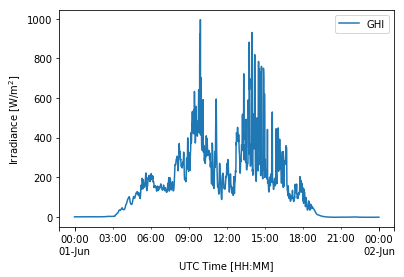

In [27]:
# Plotting GHI for a given day in the time-series
df_1min['2019-06-01']['GHI'].plot(label='GHI')
plt.ylabel('Irradiance [W/m$^2$]')
plt.xlabel('UTC Time [HH:MM]')
plt.legend(loc='best')
plt.show() # Not needed in Jupyter Notebooks but usually required in other IDEs.

We can visualize the effect of using average (*resample*) vs. instantaneous (*asfreq*) measurements when down-sampling our data.

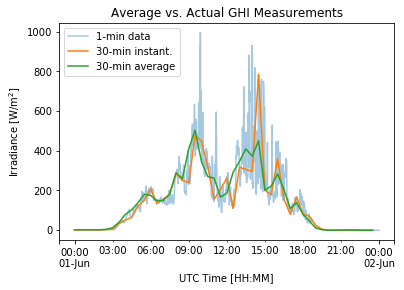

In [28]:
# Plotting GHI for a given day in the time-series
df_1min['2019-06-01']['GHI'].plot(label='1-min data', alpha=0.4) # Reference data
df_1min.asfreq('30Min')['2019-06-01']['GHI'].plot(label='30-min instant.') # Instantaneous 30-min values
df_1min.resample('30Min').mean()['2019-06-01']['GHI'].plot(label='30-min average') # Average 30-min values
plt.title('Average vs. Actual GHI Measurements') # title of the figure
plt.ylabel('Irradiance [W/m$^2$]') # y-axis label
plt.xlabel('UTC Time [HH:MM]') # x-axis label
plt.legend(loc='upper left') # insert legend
plt.show() # Not needed in Jupyter Notebooks but usually required in other IDEs.

**Plotting a time-series for a few consecutive days of interest**

Below there is an example to visualize a few consecutive days (e.g. 5 days) of interest. By using ['start date']:['end date'] it is possible to select time ranges easily with a DataFrame having a *DatetimeIndex*.

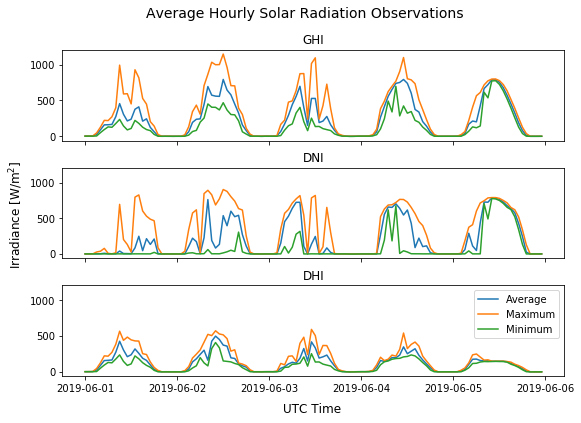

In [29]:
# Variables to plot
vars = ['GHI', 'DNI', 'DHI'] 
# Create 3 subplots, with shared X and Y axis
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(9,6))
# Add title to the plot
fig.suptitle('Average Hourly Solar Radiation Observations', fontsize=14)

for i in range(3):
    axs[i].plot(df_1min.resample('1H').mean()['2019-06-01':'2019-06-05'][vars[i]], label='Average') # Average hourly
    axs[i].plot(df_1min.resample('1H').max()['2019-06-01':'2019-06-05'][vars[i]], label='Maximum') # Max. hourly
    axs[i].plot(df_1min.resample('1H').min()['2019-06-01':'2019-06-05'][vars[i]], label='Minimum') # Min. hourly
    axs[i].set_title(vars[i]) # Title for each subplot
fig.subplots_adjust(hspace=0.3) # Adjust the white space between the subplots titles
fig.text(0.04, 0.5, 'Irradiance [W/m$^2$]', va='center', rotation='vertical', fontsize=12) # Common Y Axis
fig.text(0.51, 0.04, 'UTC Time', ha='center', fontsize=12) # Common X Axis
plt.legend(loc='upper right', ncol=1) # Legend for the last subplot or 'axs[i].legend()' in the loop to a legend to each.
plt.show()

**Plotting a time-series for a few non-consecutive days of interest**

Below there is an example to visualize a few non-consecutive days of interest, which could be the case when we would like to observe several days scattered throughout the year a single plot. In order to do this, we need to select the day of interest from the DataFrame and then reset its *DatetimeIndex*. For example:

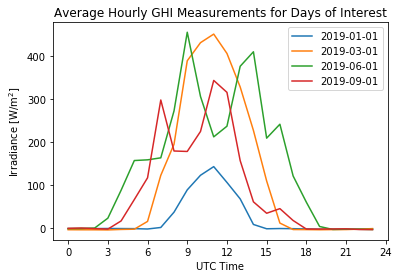

In [30]:
# List of days of interest
days = ['2019-01-01', '2019-03-01', '2019-06-01', '2019-09-01']
# Iterate over the days and plot each of them
for day in days: 
    df_day = df_1min.resample('1H').mean()[day]['GHI'].to_frame()  # average hourly of GHI for current day
    df_day = df_day.reset_index(drop=True) # reset its Index to numeric (i.e. 0,1,2,3...)
    plt.plot(df_day, label=day) # plot the current day
plt.title('Average Hourly GHI Measurements for Days of Interest') # title of the figure
plt.xticks(np.arange(0, 25, step=3), np.arange(0, 25, step=3)) # set labels positions and names
plt.ylabel('Irradiance [W/m$^2$]') # y-axis label
plt.xlabel('UTC Time') # x-axis label
plt.legend(loc='best') # insert legend
plt.show()

**Daily insolation throughout the year**

With time-series data, the hourly/daily/monthly insolation (i.e. the sum of accummulated energy) can also be analysed throughout the year with time-series data. For example, below an example to visualize the daily insolation is shown:

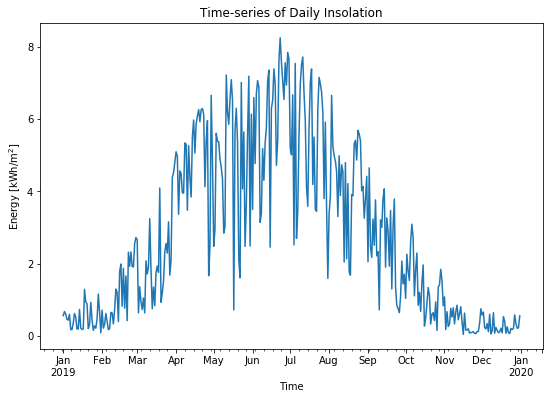

In [31]:
# Calculate the daily insolation expressed in kWh·sqm from GHI measurements
daily_energy = (df_1min['GHI'].resample("1D").sum()*(1/60))/1000 # selecting only GHI returns a Pandas Series
daily_energy = daily_energy.to_frame() # Convert the Series into a DataFrame

# Create time-series plot
daily_energy.plot(figsize=(9,6), legend=False) # plot timeseries 
plt.title('Time-series of Daily Insolation')  # add title
plt.ylabel('Energy [kWh/m$^2$]') # add Y-axis label
plt.xlabel('Time') # add X-axis label
plt.show()

Time-series data can also be visualised in other ways, for instance, as a heat map.

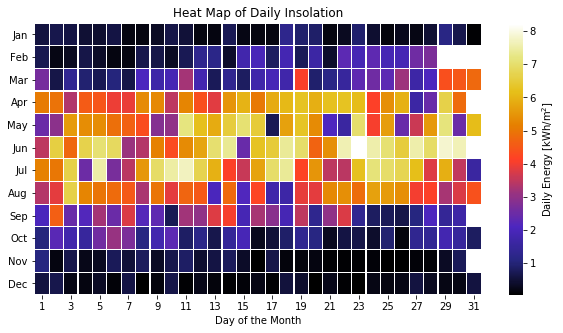

In [32]:
# Prepare the data for heat map of hourly insolation
energy_array = pd.DataFrame() # empty DataFrame for the results
for i in range(1,13): # iterate over months
    # select the data in the month and eliminate the datetimeindex
    df_month = daily_energy[daily_energy.index.month==i].reset_index(drop=True) 
    # rename the column with the number of the month
    df_month.columns = [str(i)]
    # Append results to the DataFrame
    energy_array = pd.concat([energy_array, df_month], axis=1)
# Transpose to have months in y-axis and days in x-axis
energy_array = energy_array.transpose()
# Rename the columns of the days 
energy_array.columns = np.arange(1, 32)

# Plot heat map of daily insolation
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', # month labels
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(10, 5))
ax = sns.heatmap(energy_array, cmap='CMRmap', linewidths=0.2, # plot heatmap with Seaborn (sns) library 
                xticklabels=2, annot=False,
                cbar_kws={'label': 'Daily Energy [kWh/m$^2$]'})
ax.set_title('Heat Map of Daily Insolation') # add title
ax.set_yticklabels(months,rotation=0) # add the months as tick-labels for the y-axis
ax.set_xticklabels(ax.get_xticklabels(),rotation=0) # add the days as tick-labels for the x-axis
ax.set_xlabel('Day of the Month')
plt.show()

### Section summary

This section has shown how to build and work with a time-series in Python with multiple examples:
- We have seen how to prepare a DataFrame with *DatatimeIndex* to be used as a time-series when the timestamps are given in multiple formats. 
- Changes in the temporal resolution of the data can be applied by down and up-sampling the data and the differences between 2 available methods (*asfreq* and *resample*) have been shown with examples and different sampling frequencies. 
- The interpolation of missing data in time-series can be used to up-sample the resolution of the data and examples with some methods have been shown.
- Finally, several ideas to visualize data have been presented. 

Overall, the possibilities with time-series of solar resource are many. The most useful and suitable analysis and visualizations will be determined by the application and scope of the study. 